# Reflecting the pulled data over the x and y axes

In order to try to solve the issues at the low end of the redshift/mass KDE plot, this notebook is reflecting the points over the axes and then trying to make the kde from the collection of all of those points. It's beyond impractical to try to bound the KDE to contain it in the one quadrant, so reflecting it over all the axes should copy help by reflecting the parts that are leaking over to the wrong quadrants back into the correct quadrant. Since the ridgefinder doesn't go into the other quadrants, they won't affect it in an improper way.

In [1]:
import h5py
import pandas as pd
import glob
import numpy as np
from scipy.stats import gaussian_kde
import pymc as pm
from pylab import *
import aesara.tensor as at
import aesara.tensor.extra_ops as ate
import arviz as az
from astropy import units as u
from astropy import constants as con
from astropy.cosmology import Planck18
from scipy.integrate import quad
from tqdm import tqdm
import warnings
from scipy import integrate
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('colorblind')

%matplotlib inline

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
### Functions for implementing MCMC using PyMC4

def at_interp(x, xs, ys):
    '''Custom linear interpolator'''
    x  = at.as_tensor(x)
    xs = at.as_tensor(xs)
    ys = at.as_tensor(ys)

    n = xs.shape[0]
    
    ind = ate.searchsorted(xs, x)
    ind = at.where(ind >= n, n-1, ind)
    ind = at.where(ind < 0, 0, ind)
    r = (x - xs[ind-1])/(xs[ind]-xs[ind-1]) 
    return r*ys[ind] + (1-r)*ys[ind-1]

def Ez(z, Om, w):
    opz = 1 + z
    return at.sqrt(Om*opz*opz*opz + (1-Om)*opz**(3*(1+w)))

def dCs(zs, Om, w):
    dz = zs[1:] - zs[:-1]
    fz = 1/Ez(zs, Om, w)
    I = 0.5*dz*(fz[:-1] + fz[1:]) #trapazoidally integrating
    return at.concatenate([at.as_tensor([0.0]), at.cumsum(I)])

def dLs(zs, dCs):
    return dCs*(1+zs)

def make_model(ms_obs, sigma_ms_obs, dls, zmax=100):
    zinterp = expm1(linspace(log(1), log(1+zmax), 1024))

    with pm.Model() as model:
        w = pm.Normal('w', mu=-1, sigma=0.25) 

        Om = pm.Bound('Om', pm.Normal.dist(mu=0.3, sigma=0.15), lower=0, upper=1)

        h = pm.Bound('h', pm.Lognormal.dist(mu=log(0.7), sigma=0.2), lower=0.35, upper=1.4)
#         h = pm.Lognormal('h', mu=log(0.7), sigma=0.2)
        Ode = pm.Deterministic('Ode', 1-Om)
        om = pm.Deterministic('om', Om*h*h)
        ode = pm.Deterministic('ode', Ode*h*h)

        dH= pm.Deterministic('dH', 2.99792/h)
        m0 = pm.Lognormal('m0', mu=log(35), sigma=0.5)

        dCinterp = dH*dCs(zinterp, Om, w)
        dLinterp = dLs(zinterp, dCinterp)
        
        zs = pm.Deterministic('zs', at_interp(dls, dLinterp, zinterp))

        pm.Normal('m_likelihood', mu=m0*(1+zs), sigma=sigma_ms_obs, observed=ms_obs)
    return model

def find_argmax_gridsearch(xs, fxs):
    imax = np.argmax(fxs)

    if imax == 0 or imax == len(xs)-1:
        warnings.warn('max occurs at grid boundary')
        return xs[imax]

    x0, x1, x2 = xs[imax-1], xs[imax], xs[imax+1]
    f0, f1, f2 = fxs[imax-1], fxs[imax], fxs[imax+1]

    dx01 = x0-x1
    dx12 = x1-x2
    dx20 = x2-x0

    sx01 = x0+x1
    sx12 = x1+x2
    sx20 = x2+x0

    xmax = (f2*dx01*sx01 + f0*dx12*sx12 + f1*dx20*sx20)/(2*(f2*dx01 + f0*dx12 + f1*dx20))

    return xmax


In [70]:
### Get m1_det and luminosity distances from data
f = "observations.h5"
n_mc = 15
# m_cut = 25
n_dl = 10
dl_quant_min = 0.25 #was 0.05
dl_quant_max = 0.80

with h5py.File(f, 'r') as hf:
    dl_max = np.max(hf['likelihood']['dl'])
    m_max = np.max(hf['likelihood']['m1_detector'])
    m_min = np.min(hf['likelihood']['m1_detector'])
    m_min = 25

    m1_det = np.array(hf['likelihood']['m1_detector'])
    dl = np.array(hf['likelihood']['dl'])

nevents, nsamples = dl.shape

m_grid = np.exp(np.linspace(np.log(m_min), np.log(m_max), 1024))
dl_cent = np.quantile(dl.flatten(), 
                      np.linspace(dl_quant_min, dl_quant_max, n_dl))

DLG, MG = np.meshgrid(dl_cent, m_grid, indexing='ij')

mpeak_samples = np.zeros((n_mc, n_dl))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [04:13<00:00, 16.91s/it]


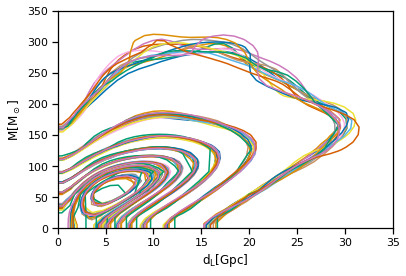

In [71]:
event_index_arr = np.arange(nevents)

for run in tqdm(range(n_mc)):
    sample_index_arr = np.random.randint(0, nsamples,  nevents)

    m = m1_det[event_index_arr, sample_index_arr]
    d = dl[event_index_arr, sample_index_arr]
    
    ###Reflecting m and d over all axes
    expanded_m = np.copy(m)
    for x in [m, -m, -m]:
        expanded_m = np.append(expanded_m, x)
        
    expanded_d = np.copy(d)
    for x in [-d, d, -d]:
        expanded_d = np.append(expanded_d, x)


    ### Set up KDE and pull out ridge

    arr = np.array([expanded_d, expanded_m])
    kde = gaussian_kde(arr)

    pdf = kde(np.array([DLG.ravel(), MG.ravel()])).reshape(DLG.shape)
    kplot = sns.kdeplot(x=expanded_d, y=expanded_m)
    kplot.set(xlim=(0, 35), ylim=(0,350), 
              ylabel=r"M[$\mathrm{M_\odot}$]", 
              xlabel=r"$\mathrm{d_L[Gpc]}$")
    for i in range(n_dl):
        mpeak_samples[run,i] = find_argmax_gridsearch(m_grid, pdf[i,:])

<AxesSubplot:ylabel='Density'>

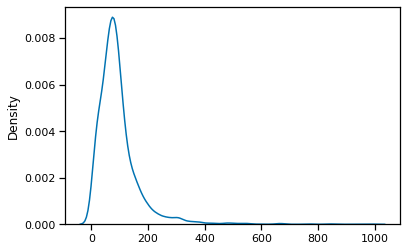

In [72]:
sns.kdeplot(m)

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

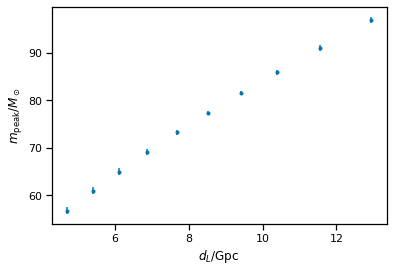

In [73]:
plt.errorbar(dl_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.')
plt.xlabel(r'$d_L / \mathrm{Gpc}$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_full...
/home/tanner/.local/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
/home/tanner/.local/lib/python3.10/site-packages/pymc/step_methods/hmc/quadpotential.py:611: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w, Om, h, m0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8842, but should be close to 0.8. Try to increase the number of tuning steps.
There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


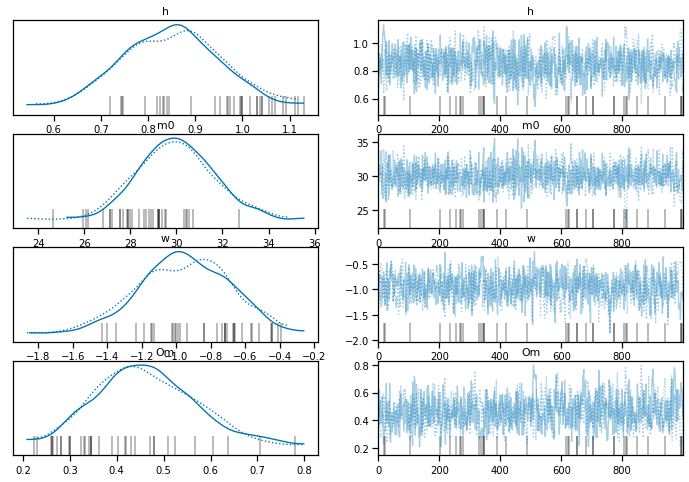

In [74]:
mu_m = np.mean(mpeak_samples, axis=0)
sigma_m = 1+np.std(mpeak_samples, axis=0)

with make_model(ms_obs=mu_m, sigma_ms_obs=sigma_m, dls=dl_cent, zmax=10) as model:
    trace = pm.sample(init='jitter+adapt_full')
    az.plot_trace(trace, var_names=['h', 'm0', 'w', 'Om'])
    trace.posterior['m_peak'] = trace.posterior.m0*(1+trace.posterior.zs) # Create another variable in the trace

Text(0, 0.5, '$m_\\mathrm{peak} / M_\\odot$')

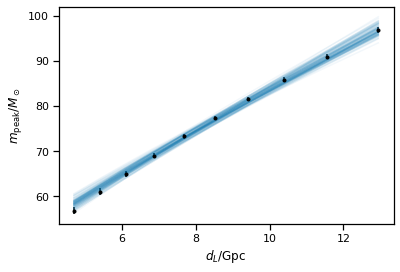

In [75]:
plt.errorbar(dl_cent, np.mean(mpeak_samples, axis=0), yerr=np.std(mpeak_samples, axis=0), fmt='.', color='k')
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(dl_cent, trace.posterior.m_peak.sel(chain=c, draw=d), color=sns.color_palette()[0], alpha=0.05)
plt.xlabel(r'$d_L / \mathrm{Gpc}$')
plt.ylabel(r'$m_\mathrm{peak} / M_\odot$')

In [76]:
cosmo = Planck18 # Planck+2018 cosmology
z_range = np.linspace(0, 3, 100)


In [77]:
def H(z, Ode, Om):
    epsilon = lambda x: (Om*(1+x)**3 + Ode)**-0.5
    return integrate.quad(epsilon, 0, z)[0]

Text(0, 0.5, '$\\mathrm{d_L/d_H}$')

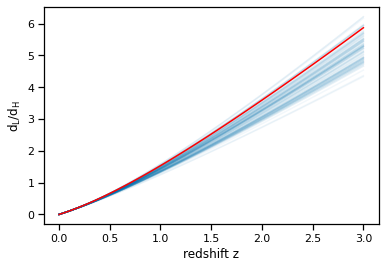

In [78]:
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
#     print(c, d, trace.posterior.h.sel(chain=c, draw=d))
    d_H = con.c/(100*u.km/u.s)*u.km/u.m/trace.posterior.h.sel(chain=c, draw=d).values
    Om = trace.posterior.Om.sel(chain=c, draw=d).values
    Ode = 1-Om
#     print(d_H, Om)
    Hz = [H(x, Ode, Om) for x in z_range]
    plt.plot(z_range, (1+z_range)*Hz, color=sns.color_palette()[0], alpha=0.05)
plt.plot(z_range, cosmo.luminosity_distance(z_range)/cosmo.hubble_distance, 'r-')
# plt.plot(z_range, cosmo.H(z_range)/cosmo.hubble_distance)
plt.xlabel("redshift z")
plt.ylabel(r"$\mathrm{d_L/d_H}$")

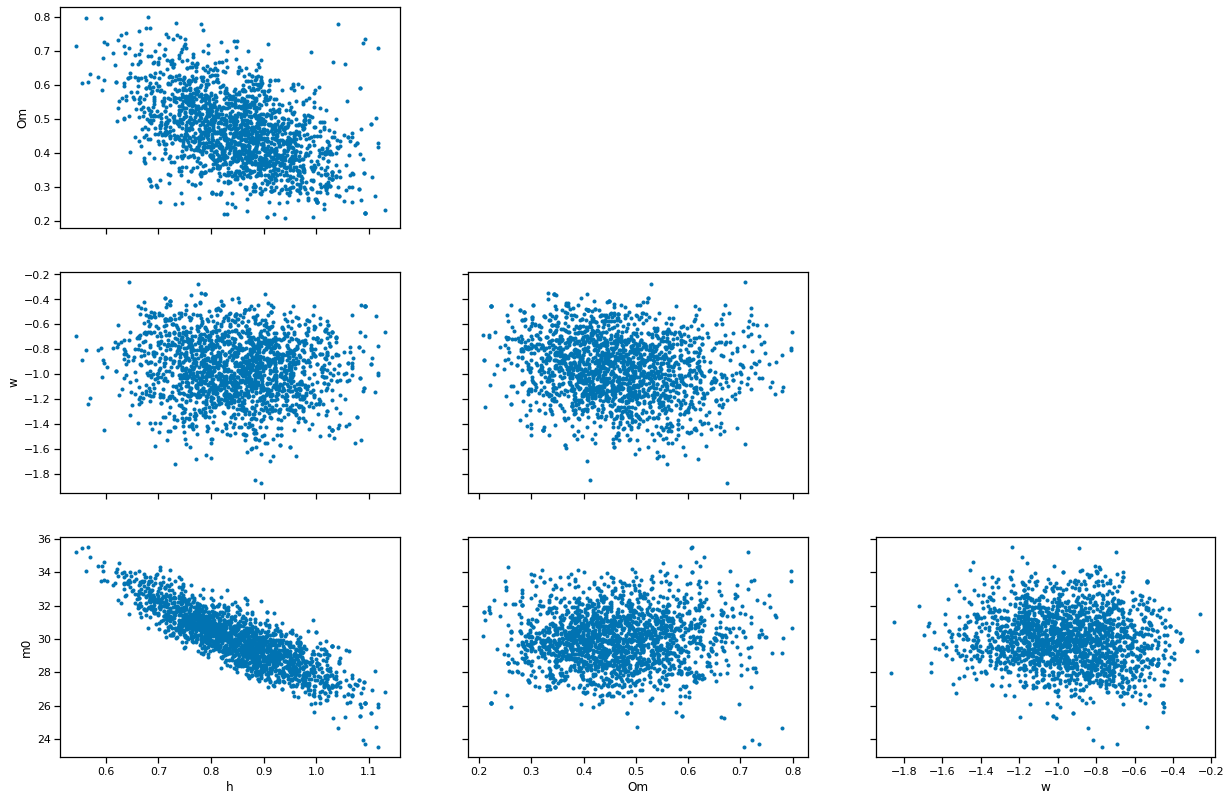

In [79]:
with model:
    az.plot_pair(trace, var_names=['h', 'Om', 'w', 'm0'])

In [80]:
print(np.mean(mpeak_samples, axis=0))

[56.82812162 61.01076067 65.01925294 69.04073063 73.29735173 77.36390305
 81.44758123 85.85119728 90.92729695 96.82088852]


It's still not getting those low bumps correctly. Maybe some other ridgefinding algorithm can help sort that out. Stay tuned...